# Expainable Artificial Intelligence
Author: Dayne N. Fradejas

**Data Set Information:**

This has been collected using direct questionnaires from the patients of Sylhet Diabetes
Hospital in Sylhet, Bangladesh and approved by a doctor.

In [12]:
import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

**Attribute Information:**

1. Age 1.20-65
2. Sex 1. Male, 2.Female
3. Polyuria 1.Yes, 2.No.
4. Polydipsia 1.Yes, 2.No.
5. sudden weight loss 1.Yes, 2.No.
6. weakness 1.Yes, 2.No.
7. Polyphagia 1.Yes, 2.No.
8. Genital thrush 1.Yes, 2.No.
9. visual blurring 1.Yes, 2.No.
10. Itching 1.Yes, 2.No.
11. Irritability 1.Yes, 2.No.
12. delayed healing 1.Yes, 2.No.
13. partial paresis 1.Yes, 2.No.
14. muscle stifness 1.Yes, 2.No.
15. Alopecia 1.Yes, 2.No.
16. Obesity 1.Yes, 2.No.
17. Class 1.Positive, 2.Negative.

In [13]:
# read data from web
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv")

# clean data with empty cells and cells with "?" and replace it with NaN
data = data.replace(r'^s*$', float('NaN'), regex = True)
data = data.replace("?", float('NaN'))

# drop rows with NaN values
data = data.dropna()

# output data
data

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


# Split Data and Encode Data
Make sure to split data and then use label encoder for categorical data

In [14]:
from sklearn.preprocessing import LabelEncoder
def encode_columns(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

# Specify the columns to encode
columns_to_encode = ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class']

# Apply label encoding to the specified columns
data = encode_columns(data, columns_to_encode)

# prepare data
X = StandardScaler().fit_transform(data.iloc[:,:-1])
y = data.iloc[:,-1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state = 85,
                                                    stratify=y)

## Create an AutoML in Optuna 

In [15]:
import optuna
from time import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

class AutoMLOptuna:
    """
    An AutoML Algorithm to search for the best algorithm for binary classification
    of heart disease
    Naive Bays, and Decision Trees
    """

    def __init__(self, X, y):
        """
        X: Input raw data to be processed.
        y: Input binary classification of 0 and 1.
        """
        self.X = StandardScaler().fit_transform(X)
        self.y = y

        # Apply StandardScaler

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state = 42, stratify=y)
  
    
    def create_model(self, trial, model="all"):
        if model == "all":
            model_type = trial.suggest_categorical('model_type', ['MLP', 'RandomForest', 'XGBoost', 'LogisticRegression', 'NaiveBayes', 'SVC', 'KNN'])
        else:
            model_type = trial.suggest_categorical('model_type', ['RandomForest'])
           
        if model_type == 'MLP':
            hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
            hidden_units = trial.suggest_int('hidden_units', 32, 64)
            activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
            learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
            alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)

            model = MLPClassifier(
                hidden_layer_sizes=(hidden_units,) * hidden_layers,
                activation=activation,
                learning_rate_init=learning_rate,
                alpha=alpha
            )
         

        elif model_type == 'RandomForest':           
            n_estimators = trial.suggest_int('n_estimators', 100, 2000)
            max_depth = trial.suggest_int('max_depth', 1, 20)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

            # Create and train the Random Forest classifier with the suggested hyperparameters
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                           min_samples_split=min_samples_split, 
                                           min_samples_leaf=min_samples_leaf, 
                                           max_features=max_features, n_jobs = -1)           

        elif model_type == 'XGBoost':
            learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log = True)
            n_estimators = trial.suggest_int('n_estimators', 50, 1000)
            max_depth = trial.suggest_int('max_depth', 1, 10)
            model = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, n_jobs = -1)
        
        elif model_type == 'LogisticRegression':
            penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
            if penalty == 'l1':
                solver = 'saga'
            else:
                solver = 'lbfgs'
            regularization = trial.suggest_float('Logistic-regularization', 
                                                  0.01, 100, log=True)
            model = LogisticRegression(penalty=penalty, 
                                        C=regularization, 
                                        solver=solver)
            
        elif model_type == 'NaiveBayes':
            model = GaussianNB()


        elif model_type == 'SVC':
            C = trial.suggest_float('C', 1e-4, 1e4, log=True)
            gamma = trial.suggest_float('gamma', 1e-4, 1e4, log=True)
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
            model = SVC(C=C, gamma=gamma, kernel=kernel)

        elif model_type == 'KNN':
            n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
            model = KNeighborsClassifier(n_neighbors=n_neighbors)

        # Rest of the models
        if trial.should_prune():
            raise optuna.TrialPruned()

        return model

    def objective(self, trial):
        """
        Define the objective func. as the 10-fold cross-validation score
        trial : number of trials
        """       
        model = self.create_model(trial)
        scores = cross_val_score(model, self.X_train, self.y_train, cv=10)
        return np.mean(scores)

    def objective_f1(self,trial):
        """
        Define the objective function 
        """
        # Perform cross-validation and compute the average F1 score
        model = self.create_model(trial,"RandomForest")
        f1_scores = cross_val_score(model, self.X_train, self.y_train, cv=10, scoring='f1_macro')
        return f1_scores.mean()
    
    def AutoML_test(self, validator="mean_score"):
        """
        AutoML test function to find the best optimized 
        
        validator : a parameter to state which validation will be used to detect the best parameter
        """
        start = time()
        study = optuna.create_study(direction='maximize')
        if validator == "f1_score":
            study.optimize(self.objective_f1, n_trials=150)
        else:
            study.optimize(self.objective, n_trials=150)
        best_params = study.best_params
        print("\n\nBest parameters: ", best_params)
        
        if validator == "f1_score":
            best_model = self.create_model(study.best_trial, model='RandomForest')
        else:
            best_model = self.create_model(study.best_trial)            
        
        best_model.fit(self.X_train, self.y_train)

        scores = cross_val_score(best_model, self.X_train, self.y_train, cv=10) 
        print("Best cross-validation score: %.5f" % np.mean(scores))
        y_pred = best_model.predict(self.X_test)
        print("Performance on test data: %.5f" % accuracy_score(self.y_test,y_pred))
        print("F1-Score of Model: %.5f" % f1_score(self.y_test, y_pred, average='weighted'))
        total_time = time()-start
        print("Runtime: %.4f sec" % total_time)

  

In [17]:
# look for the best tuned model
automl = AutoMLOptuna(X,y)
automl.AutoML_test()

[I 2023-06-13 15:27:35,414] A new study created in memory with name: no-name-48e657bb-bd3c-43f3-977d-19b72569537f
[I 2023-06-13 15:27:35,799] Trial 0 finished with value: 0.9011261261261263 and parameters: {'model_type': 'KNN', 'n_neighbors': 4}. Best is trial 0 with value: 0.9011261261261263.
[I 2023-06-13 15:27:35,831] Trial 1 finished with value: 0.9227477477477478 and parameters: {'model_type': 'LogisticRegression', 'penalty': 'l1', 'Logistic-regularization': 0.17091401626861}. Best is trial 1 with value: 0.9227477477477478.
[I 2023-06-13 15:27:58,283] Trial 2 finished with value: 0.9256006006006006 and parameters: {'model_type': 'SVC', 'C': 2074.9568347348154, 'gamma': 0.000600267553568796, 'kernel': 'linear'}. Best is trial 2 with value: 0.9256006006006006.
[I 2023-06-13 15:28:01,135] Trial 3 finished with value: 0.9558558558558559 and parameters: {'model_type': 'MLP', 'hidden_layers': 2, 'hidden_units': 59, 'activation': 'tanh', 'learning_rate': 0.0007874861720560303, 'alpha': 0

[I 2023-06-13 15:28:47,205] Trial 33 finished with value: 0.9697447447447447 and parameters: {'model_type': 'KNN', 'n_neighbors': 1}. Best is trial 27 with value: 0.9697447447447447.
[I 2023-06-13 15:28:47,512] Trial 34 finished with value: 0.8983483483483484 and parameters: {'model_type': 'KNN', 'n_neighbors': 6}. Best is trial 27 with value: 0.9697447447447447.
[I 2023-06-13 15:28:47,819] Trial 35 finished with value: 0.9697447447447447 and parameters: {'model_type': 'KNN', 'n_neighbors': 1}. Best is trial 27 with value: 0.9697447447447447.
[I 2023-06-13 15:28:48,123] Trial 36 finished with value: 0.9230480480480481 and parameters: {'model_type': 'KNN', 'n_neighbors': 7}. Best is trial 27 with value: 0.9697447447447447.
[I 2023-06-13 15:28:48,431] Trial 37 finished with value: 0.9064564564564564 and parameters: {'model_type': 'KNN', 'n_neighbors': 12}. Best is trial 27 with value: 0.9697447447447447.
[I 2023-06-13 15:28:48,739] Trial 38 finished with value: 0.9011261261261263 and par

[I 2023-06-13 15:29:16,552] Trial 74 finished with value: 0.9256006006006006 and parameters: {'model_type': 'SVC', 'C': 33.289763605221694, 'gamma': 0.030352326142886153, 'kernel': 'linear'}. Best is trial 70 with value: 0.9724474474474475.
[I 2023-06-13 15:29:16,839] Trial 75 finished with value: 0.934009009009009 and parameters: {'model_type': 'KNN', 'n_neighbors': 2}. Best is trial 70 with value: 0.9724474474474475.
[I 2023-06-13 15:29:24,779] Trial 76 finished with value: 0.898048048048048 and parameters: {'model_type': 'RandomForest', 'n_estimators': 1487, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 70 with value: 0.9724474474474475.
[I 2023-06-13 15:29:24,790] Trial 77 finished with value: 0.8951951951951953 and parameters: {'model_type': 'NaiveBayes'}. Best is trial 70 with value: 0.9724474474474475.
[I 2023-06-13 15:29:25,083] Trial 78 finished with value: 0.9011261261261263 and parameters: {'model_type': 'KNN', 'n_neig

[I 2023-06-13 15:29:45,611] Trial 116 finished with value: 0.8623873873873873 and parameters: {'model_type': 'SVC', 'C': 0.328596941128746, 'gamma': 0.0030598395115464688, 'kernel': 'rbf'}. Best is trial 70 with value: 0.9724474474474475.
[I 2023-06-13 15:29:45,911] Trial 117 finished with value: 0.934009009009009 and parameters: {'model_type': 'KNN', 'n_neighbors': 2}. Best is trial 70 with value: 0.9724474474474475.
[I 2023-06-13 15:29:46,209] Trial 118 finished with value: 0.8816816816816818 and parameters: {'model_type': 'KNN', 'n_neighbors': 20}. Best is trial 70 with value: 0.9724474474474475.
[I 2023-06-13 15:29:46,225] Trial 119 finished with value: 0.8951951951951953 and parameters: {'model_type': 'NaiveBayes'}. Best is trial 70 with value: 0.9724474474474475.
[I 2023-06-13 15:29:50,981] Trial 120 finished with value: 0.8816066066066066 and parameters: {'model_type': 'RandomForest', 'n_estimators': 817, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_fea



Best parameters:  {'model_type': 'SVC', 'C': 5229.832460375943, 'gamma': 0.1433692838359905, 'kernel': 'rbf'}
Best cross-validation score: 0.97245
Performance on test data: 0.98077
F1-Score of Model: 0.98074
Runtime: 275.6270 sec


Best parameters:  {'model_type': 'SVC', 'C': 5229.832460375943, 'gamma': 0.1433692838359905, 'kernel': 'rbf'}
Best cross-validation score: 0.97245
Performance on test data: 0.98077
F1-Score of Model: 0.98074
Runtime: 275.6270 sec

## Hypertuning the Random Forest Classifier 
Note: This is based on the paper

In [18]:
automl = AutoMLOptuna(X,y)
automl.AutoML_test("f1_score")

[I 2023-06-13 15:36:07,463] A new study created in memory with name: no-name-52be5141-552c-4b55-8290-d9f6e12fbe07
[I 2023-06-13 15:36:19,375] Trial 0 finished with value: 0.9442418330491315 and parameters: {'model_type': 'RandomForest', 'n_estimators': 1947, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9442418330491315.
[I 2023-06-13 15:36:28,971] Trial 1 finished with value: 0.8999685117479229 and parameters: {'model_type': 'RandomForest', 'n_estimators': 1871, 'max_depth': 1, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9442418330491315.
[I 2023-06-13 15:36:36,645] Trial 2 finished with value: 0.9105985992290775 and parameters: {'model_type': 'RandomForest', 'n_estimators': 1159, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 0 with value: 0.9442418330491315.
[I 2023-06-13 15:36:41,233] Trial 3 fi

[I 2023-06-13 15:38:41,629] Trial 29 finished with value: 0.9361747484011351 and parameters: {'model_type': 'RandomForest', 'n_estimators': 878, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:38:44,720] Trial 30 finished with value: 0.9353060845204133 and parameters: {'model_type': 'RandomForest', 'n_estimators': 394, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:38:47,097] Trial 31 finished with value: 0.9561418820256424 and parameters: {'model_type': 'RandomForest', 'n_estimators': 222, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:38:50,888] Trial 32 finished with value: 0.9560988522832602 and parameters: {'model_type': 'RandomForest', 'n_estimators': 427, 'max_dept

[I 2023-06-13 15:40:56,221] Trial 58 finished with value: 0.9383631884470824 and parameters: {'model_type': 'RandomForest', 'n_estimators': 1144, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:41:06,469] Trial 59 finished with value: 0.9072119913873354 and parameters: {'model_type': 'RandomForest', 'n_estimators': 1846, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:41:14,396] Trial 60 finished with value: 0.9444301149765438 and parameters: {'model_type': 'RandomForest', 'n_estimators': 990, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:41:18,608] Trial 61 finished with value: 0.9679738680791644 and parameters: {'model_type': 'RandomForest', 'n_estimators': 478, 'max_de

[I 2023-06-13 15:43:05,209] Trial 87 finished with value: 0.9415144333374579 and parameters: {'model_type': 'RandomForest', 'n_estimators': 249, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:43:07,845] Trial 88 finished with value: 0.9679738680791644 and parameters: {'model_type': 'RandomForest', 'n_estimators': 372, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:43:11,569] Trial 89 finished with value: 0.9561418820256424 and parameters: {'model_type': 'RandomForest', 'n_estimators': 459, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:43:15,072] Trial 90 finished with value: 0.9536962945433711 and parameters: {'model_type': 'RandomForest', 'n_estimators': 304, 'max_de

[I 2023-06-13 15:44:55,727] Trial 116 finished with value: 0.9530971489809094 and parameters: {'model_type': 'RandomForest', 'n_estimators': 666, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:45:00,007] Trial 117 finished with value: 0.9385041890506178 and parameters: {'model_type': 'RandomForest', 'n_estimators': 448, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:45:03,267] Trial 118 finished with value: 0.9650637755064031 and parameters: {'model_type': 'RandomForest', 'n_estimators': 503, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:45:07,754] Trial 119 finished with value: 0.9410101555618159 and parameters: {'model_type': 'RandomForest', 'n_estimators': 599, 'ma

[I 2023-06-13 15:46:56,079] Trial 145 finished with value: 0.9530971489809094 and parameters: {'model_type': 'RandomForest', 'n_estimators': 569, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:46:59,091] Trial 146 finished with value: 0.9679738680791644 and parameters: {'model_type': 'RandomForest', 'n_estimators': 502, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:47:02,268] Trial 147 finished with value: 0.9591048449886053 and parameters: {'model_type': 'RandomForest', 'n_estimators': 346, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 20 with value: 0.9679738680791644.
[I 2023-06-13 15:47:09,455] Trial 148 finished with value: 0.9679738680791644 and parameters: {'model_type': 'RandomForest', 'n_estimators': 1063, 'ma



Best parameters:  {'model_type': 'RandomForest', 'n_estimators': 371, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best cross-validation score: 0.96959
Performance on test data: 0.98718
F1-Score of Model: 0.98718
Runtime: 670.3922 sec


Best parameters:  {'model_type': 'RandomForest', 'n_estimators': 1176, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}
* Best cross-validation score: 0.96959
* Performance on test data (accuracy): 0.98718
* **F1-Score of Model: 0.98718**
* Runtime: 1358.8245 sec

# Predicting High School Student Performance

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

**Attribute Information:**

Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1. school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
2. sex - student's sex (binary: 'F' - female or 'M' - male)
3. age - student's age (numeric: from 15 to 22)
4. address - student's home address type (binary: 'U' - urban or 'R' - rural)
5. famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
6. Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
9. Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
10. Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
11. reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
12. guardian - student's guardian (nominal: 'mother', 'father' or 'other')
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4)
16. schoolsup - extra educational support (binary: yes or no)
17. famsup - family educational support (binary: yes or no)
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. activities - extra-curricular activities (binary: yes or no)
20. nursery - attended nursery school (binary: yes or no)
21. higher - wants to take higher education (binary: yes or no)
22. internet - Internet access at home (binary: yes or no)
23. romantic - with a romantic relationship (binary: yes or no)
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high)
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high)
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. health - current health status (numeric: from 1 - very bad to 5 - very good)
30. absences - number of school absences (numeric: from 0 to 93)

*these grades are related with the course subject, Math or Portuguese:*
31. G1 - first period grade (numeric: from 0 to 20)
31. G2 - second period grade (numeric: from 0 to 20)
32. G3 - final grade (numeric: from 0 to 20, output target)

In [2]:
# read data from web
data = pd.read_csv("student-mat.csv", sep=';')

# clean data with empty cells and cells with "?" and replace it with NaN
data = data.replace(r'^s*$', float('NaN'), regex = True)
data = data.replace("?", float('NaN'))

# drop rows with NaN values
data = data.dropna()

# output data
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

def encode_columns(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

# Specify the columns to encode
columns_to_encode = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian','studytime', 'schoolsup', 'famsup', 'paid', 'activities', 
                     'nursery','higher', 'internet', 'romantic']

# Apply label encoding to the specified columns
data = encode_columns(data, columns_to_encode)

# prepare data
X = StandardScaler().fit_transform(data.iloc[:,:-1])
y = data.iloc[:,-1].to_numpy()


In [21]:
from time import time
import warnings
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")

# Create an OptunaAutoML Class
class AutoML:
    """
    An AutoML Algorithm to search for the best algorithm for binary classification
    of heart disease
    Naive Bays, and Decision Trees
    """

    def __init__(self, X, y):
        """
        X: Input raw data to be processed.
        y: Input binary classification of 0 and 1.
        """
        
        self.X = StandardScaler().fit_transform(X)
        self.y = y

        # Apply StandardScaler

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state = 42)
  
    
    def create_model(self,trial):
        model_type = trial.suggest_categorical('model_type', ['LogisticRegression','RandomForest', 'XGBoost', 'NaiveBayes','SVR'])
        
        if model_type == 'MLP':
            hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
            hidden_units = trial.suggest_int('hidden_units', 32, 64)
            activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
            learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
            alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)

            model = MLPRegressor(
                hidden_layer_sizes=(hidden_units,) * hidden_layers,
                activation=activation,
                learning_rate_init=learning_rate,
                alpha=alpha
            )

        elif model_type == 'RandomForest':
            n_estimators = trial.suggest_int('n_estimators', 100, 2000)
            max_depth = trial.suggest_int('max_depth', 1, 20)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features
            )

        elif model_type == 'XGBoost':
            n_estimators = trial.suggest_int('n_estimators', 100, 2000)
            max_depth = trial.suggest_int('max_depth', 1, 20)
            learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
            subsample = trial.suggest_float('subsample', 0.1, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
            alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)

            model = XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                learning_rate=learning_rate,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                alpha=alpha
            )

        elif model_type == 'LogisticRegression':
            penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
            if penalty == 'l1':
                solver = 'saga'
            else:
                solver = 'lbfgs'
            regularization = trial.suggest_float('Logistic-regularization', 
                                                 0.01, 100, log=True)
            model = LogisticRegression(penalty=penalty, 
                                       C=regularization, 
                                       solver=solver)

        elif model_type == 'NaiveBayes':
            model = GaussianNB()

        elif model_type == 'SVR':
            C = trial.suggest_float('C', 1e-10, 1e10, log=True)
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
            degree = trial.suggest_int('degree', 1, 5)
            gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

            model = SVR(
                C=C,
                kernel=kernel,
                degree=degree,
                gamma=gamma
            )

        elif model_type == 'KNN':
            n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

            model = KNeighborsRegressor(
                n_neighbors=n_neighbors,
                weights=weights,
                algorithm=algorithm
            )
            
        if trial.should_prune():
            raise optuna.TrialPruned() 

        return model

    def objective(self, trial):
        """
        Define the objective function as the 10-fold cross-validation R2 score
        trial : number of trials
        """
        model = self.create_model(trial)
        scores = cross_val_score(model, self.X_train, self.y_train, cv=10, scoring='r2')
        return np.mean(scores)
    
        
    def get_model_scores(self):
        """
        Get the best R2 scores of each model evaluated by Optuna
        """
        model_scores = {}

        def callback(study, trial):
            model = self.create_model(trial)
            model_name = trial.params['model_type']  # Get the model name
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_train)
            r2 = r2_score(self.y_train, y_pred)
            model_scores[trial.number] = {'model_name': model_name, 'r2_score': r2}
            
        start = time()
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=25, callbacks=[callback])
        best_params = study.best_params
        
        # print best model
        best_model = self.create_model(study.best_trial)                    
        best_model.fit(self.X_train, self.y_train)
        
        print(f"Best Params: {study.best_trial.params}")
        print(f"Best model: {study.best_trial.params['model_type']}")
        scores = cross_val_score(best_model, self.X_train, self.y_train, cv=5) 
        print("Best cross-validation score: %.5f" % np.mean(scores))
        y_pred = best_model.predict(self.X_test)
        print("R2-Score of Model: %.5f" % r2_score(self.y_test, y_pred))
        total_time = time()-start
        print("Runtime: %.4f sec" % total_time)
        
        return model_scores
    

In [22]:
# look for the best tuned model
automl = AutoML(X, y)
scores = automl.get_model_scores()

[I 2023-06-07 13:39:54,302] A new study created in memory with name: no-name-c3969d8e-177a-4c8c-a381-53ab04b67f00
[I 2023-06-07 13:39:54,513] Trial 0 finished with value: 0.6124906342551426 and parameters: {'model_type': 'LogisticRegression', 'penalty': 'l2', 'Logistic-regularization': 0.7914583333373922}. Best is trial 0 with value: 0.6124906342551426.
[I 2023-06-07 13:39:54,596] Trial 1 finished with value: 0.656906433920695 and parameters: {'model_type': 'SVR', 'C': 2956770402.1899805, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'}. Best is trial 1 with value: 0.656906433920695.
[I 2023-06-07 13:39:54,680] Trial 2 finished with value: 0.1476347862311563 and parameters: {'model_type': 'SVR', 'C': 444400.7212172526, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}. Best is trial 1 with value: 0.656906433920695.
[I 2023-06-07 13:39:54,714] Trial 3 finished with value: 0.5224461873774143 and parameters: {'model_type': 'NaiveBayes'}. Best is trial 1 with value: 0.656906433920695.
[I 202

Best Params: {'model_type': 'XGBoost', 'n_estimators': 1721, 'max_depth': 7, 'learning_rate': 0.09199041456064999, 'subsample': 0.9737687939262354, 'colsample_bytree': 0.7164686948447542, 'alpha': 1.909456818070867e-05}
Best model: XGBoost
Best cross-validation score: 0.88485
R2-Score of Model: 0.84105
Runtime: 94.5772 sec


In [23]:
# Output the summary of r2_score (Training data)
pd.DataFrame(scores).T.sort_values('r2_score', ascending=False).drop_duplicates(subset='model_name')

,model_name,r2_score
16,XGBoost,1.0
1,SVR,0.999538
14,LogisticRegression,0.965499
5,RandomForest,0.873069
4,NaiveBayes,0.528733


## Explainability AI Analysis

In [33]:
# read data from web
data = pd.read_csv("student-mat.csv", sep=';')

# clean data with empty cells and cells with "?" and replace it with NaN
data = data.replace(r'^s*$', float('NaN'), regex = True)
data = data.replace("?", float('NaN'))

# drop rows with NaN values
data = data.dropna()

# output data
data.columns

# prepare data
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [56]:


rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0]) 
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                     'Mjob', 'Fjob', 'reason', 'guardian','studytime', 'schoolsup','famsup', 
                       'paid', 'activities','nursery','higher', 'internet', 'romantic','random_cat']
numerical_columns = ['age','traveltime','failures','famrel','freetime','goout','Dalc','Walc',
                     'health','absences','G1','G2','random_num']

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.head()


,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,random_num
81,GP,M,U,GT3,T,2,3,other,other,home,...,5,3,2,1,2,5,4,11,10,-0.505880
344,GP,F,U,GT3,T,2,3,at_home,other,course,...,4,3,3,1,2,3,4,11,10,0.668101
336,GP,F,R,GT3,A,3,1,services,at_home,home,...,5,4,3,1,2,5,12,14,13,2.389878
124,GP,F,U,GT3,T,2,2,other,other,home,...,5,4,4,1,1,5,0,8,7,-0.317369
250,GP,M,U,GT3,T,3,2,services,other,course,...,4,4,5,2,4,5,0,6,8,0.467780


In [58]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

xgboost = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", XGBRegressor(
                n_estimators=1721,
                max_depth=7,
                learning_rate=0.09199041456064999,
                subsample=0.9737687939262354,
                colsample_bytree=0.7164686948447542,
                alpha=1.909456818070867e-05)),
    ]
)
xgboost.fit(X_train, y_train)
print(f"XGBoost train accuracy: {xgboost.score(X_train, y_train):.2f}")
print(f"XGBoost test accuracy: {xgboost.score(X_test, y_test):.2f}")
        


XGBoost train accuracy: 1.00
XGBoost test accuracy: 0.85


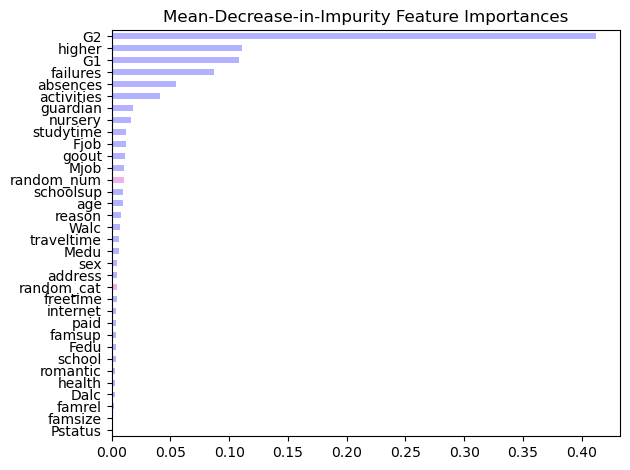

In [60]:
feature_names = xgboost[:-1].get_feature_names_out()
feature_importances = xgboost[-1].feature_importances_
mdi_importances = pd.Series(feature_importances,index=feature_names).sort_values(ascending=True)
colors = ['b']*len(mdi_importances)
colors[(mdi_importances.index).tolist().index('random_num')] = 'm'
colors[(mdi_importances.index).tolist().index('random_cat')] = 'm'
ax = mdi_importances.plot.barh(color=colors,alpha=0.3)
ax.set_title("Mean-Decrease-in-Impurity Feature Importances")
ax.figure.tight_layout()

You can see in the results of the model that G2, higher, G1, failures, and absences greatly affects the G3 of the student in the prediction

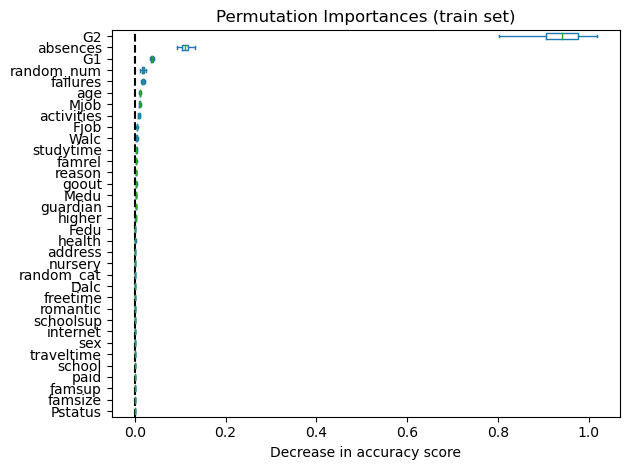

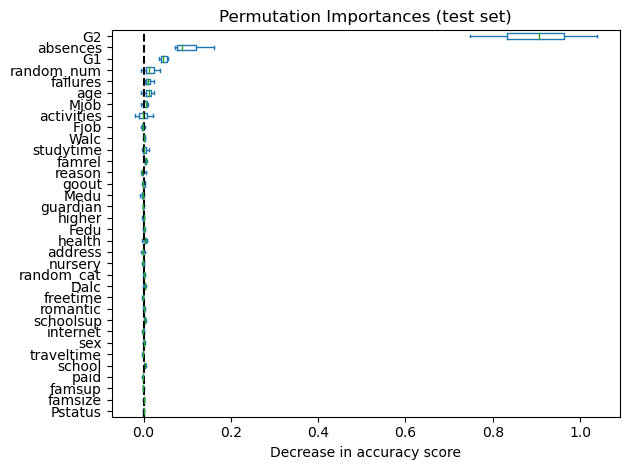

In [62]:
from sklearn.inspection import permutation_importance

train_result = permutation_importance(xgboost, X_train, y_train, n_repeats=10, random_state=42)
test_results = permutation_importance(xgboost, X_test, y_test, n_repeats=10, random_state=42)
sorted_importances_idx = train_result.importances_mean.argsort()
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

# Explainable AI using Shap Values

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['school', 'sex', 'address',
                                                   'famsize', 'Pstatus', 'Medu',
                                                   'Fedu', 'Mjob', 'Fjob',
                                                   'reason', 'guardian',
                                                   'studytime', 'schoolsup',
                                                   'famsup', 'paid',
                                                   'activities', 'nursery',
                                                   'higher', 'internet',
                                 

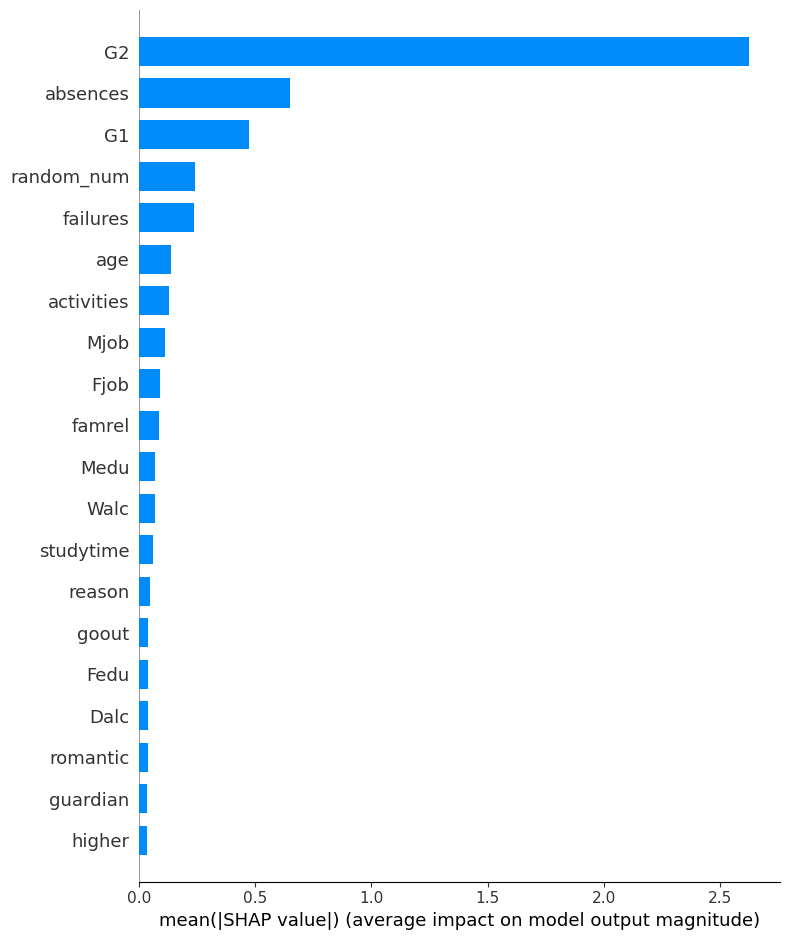

In [68]:
import shap
print(xgboost)

# The next few lines help us apply SHAP values on a Pipeline model
explainer = shap.TreeExplainer(xgboost['classifier'])
observations = xgboost['preprocess'].transform(X_test)
shap_values = explainer.shap_values(observations)

# Plot the feature importance using SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar")

The Shap values also shows that G2 is the highest predictor of the model. In the data, the random_number shows a high predictor rather than the values given. In addition, it shows shows that the features below the random_number features are somehow as good as a random values in the model and not a good indictor of good feature to produce an accurate predictor in the model. 

school                GP
sex                    F
address                U
famsize              GT3
Pstatus                T
Medu                   1
Fedu                   1
Mjob            services
Fjob             teacher
reason        reputation
guardian          mother
studytime              3
schoolsup             no
famsup               yes
paid                 yes
activities            no
nursery              yes
higher               yes
internet             yes
romantic              no
random_cat             1
age                   17
traveltime             1
failures               0
famrel                 4
freetime               3
goout                  3
Dalc                   1
Walc                   1
health                 3
absences               6
G1                    13
G2                    12
random_num     -1.291036
Name: 287, dtype: object


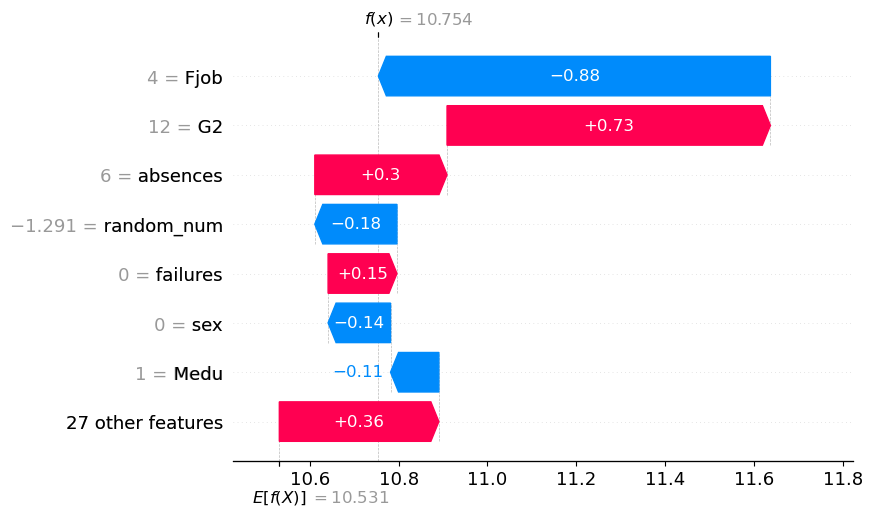

In [83]:
sv = explainer(observations)
y_test_pred = xgboost.predict(X_test)

student_no = 5
# You can set the passenger numbers here.
print(X_test.iloc[student_no])

# Create the SHAP explanation object
exp = shap.Explanation(
        values=sv[student_no],
        base_values=sv.base_values,
        data=X.values,
        feature_names=X.columns
    )

shap.plots.waterfall(exp, max_display=8)

In the waterfall figure above, it show sthat Fjob has been an important feature at the same G2 in the prediction of the regression value. This 2 features shows how the maginture of the values greatly affects the results in the model. 